# Human's emotion recognition using thermal images
## *TEACHER: NGUYEN VIET HUNG*
## *MEMBER*
- Vuong Le Minh Nguyen
- Luong Cong Tam

#### Import Library & Settings

In [1]:
import pandas as pd
import sklearn
import scipy
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import cv2
import glob
import random
import IPython.display as display
from configparser import ConfigParser
import re
from time import sleep

np.set_printoptions(threshold=np.inf) # Setting for full numpy matrices printin

In [2]:
# Load db config:
dbconfig = ConfigParser()
dbconfig.read('database.ini')

# Assign dbDir with local config:
dbDir = dbconfig['LOCAL']['location'] #Database directory
eDir = {
    "angry":"anger",
    "fear":"fear",
    "happy":"happy",
    "sad":"sadness",
    "neutral":"neutral"
} #Name of directory of each Emotion

#### Function definition

In [3]:
def frameShow(frame):
    w, h = frame.shape
    ret = cv2.imencode('.jpeg',frame)[1]
    i = display.Image(data=ret, width = w, height = h)
    display.display(i)
    sleep(0.05)
#     display.clear_output(True)

In [4]:
def getSVXFiles(fd):
    return glob.glob(fd + '/*.svx') + glob.glob(fd + '/*.SVX')

In [5]:
def getGrayImage(frame, bit_depth = 8):
    Tmax = np.amax(frame)
    Tmin = np.amin(frame)
    
    # Map current frame to 8-bit grayscale:
    lbound = np.floor(Tmin)
    rbound = np.ceil(Tmax)
    scale = 2**bit_depth
    grayImg = ((frame-lbound)*scale/(rbound-lbound)).astype(np.uint8)
    
    return grayImg

In [73]:
def getFace(frame, minTemp = 29.0, fitEllipsePoint = 200):
    xFrame, yFrame = frame.shape
    topEdge, rightEdge, bottomEdge, leftEdge = xFrame, 0, 0, yFrame
    ret = np.insert(frame.copy(), 0, np.zeros((3, yFrame)), 0) # Do not change anythings in input array
    
    (x, y) = np.where(ret < minTemp)
    ret[x, y] = 0
    
    (x, y) = np.where(ret[3:150, :] >= minTemp)
    
    topEdge = max(np.min(x) - 3, 0)
    rightEdge = min(np.max(y) + 10, yFrame)
    bottomEdge = xFrame
    leftEdge = max(np.min(y) - 10, 0)
    
    gray = getGrayImage(ret[topEdge:bottomEdge, leftEdge:rightEdge])

    blured = cv2.GaussianBlur(gray.copy(),(5,5),1)
    cannied = cv2.Canny(blured,20,80)
    
    kernelSize = (5,5)
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,kernelSize)
    cannied = cv2.dilate(cannied, kernel)
    
    _, contours, hierarchy = cv2.findContours(cannied, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    drawedContours = cv2.drawContours(blured,contours,-1,(255,0,0), 1)
    
    maxEllipse = 0
#     print(maxEllipse)
    
    # Find biggest contours
    for i, c in enumerate(contours):
        if c.shape[0] > contours[maxEllipse].shape[0] and c.shape[0] > fitEllipsePoint and hierarchy[0, i, 3] == -1:
#             print(c.shape, i)
            maxEllipse = i
#     print(contours[maxEllipse].shape)
    maxEllipse = cv2.fitEllipse(contours[maxEllipse])
    rotateAngle = maxEllipse[2] if maxEllipse[2] < 90 else -(180 - maxEllipse[2])
#     print(rotateAngle)
            
    drawing = np.zeros((gray.shape[0], gray.shape[1], 3), dtype=np.uint8)
    mask = drawing.copy()
#     for i, c in enumerate(contours):
    color = (255, 255, 255)
#         if c.shape[0] > fitEllipsePoint and hierarchy[0, i, 3] == -1:
#     print(maxEllipse)
    cv2.ellipse(drawing, maxEllipse, color, 2)
    cv2.ellipse(mask, maxEllipse, color, -1)
    cv2.drawContours(drawing, contours, -1, (255,0,0))
    
    mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
    
    crop = cv2.bitwise_and(gray, mask)
    
    cols, rows = crop.shape[1]//2, crop.shape[0]//2
    M = cv2.getRotationMatrix2D((cols, rows), rotateAngle, 1)
    crop = cv2.warpAffine(crop, M, (crop.shape[1], crop.shape[0]))
    
    (x, y) = np.where(crop != 0)
    (topx, topy) = (np.min(x), np.min(y))
    (bottomx, bottomy) = (np.max(x), np.max(y))
    
    face = crop[topx:bottomx, topy:bottomy]
    
    face = cv2.resize(face, (150,180))
    
#     plt.figure(num=None,figsize=(21,10),dpi=100)
    
#     plt.subplot(141)
#     plt.imshow(gray)

#     plt.subplot(142)
#     plt.imshow(cannied)
    
#     plt.subplot(143)
#     plt.imshow(drawing)
#     plt.subplot(144)
#     plt.imshow(face)
    
#     plt.show()
    
    return face

In [7]:
def getTROIs(face, lowerpart, upperpart):
    
    # Get pixel intensities of the face:
    intensity = np.bincount(face.flatten(), minlength = 256)
    intensity[0] = 0 # remove all zero-meaning pixels
    intensity = (intensity / np.sum(intensity)).tolist()
    
    
    # Remove lowerpart of pixel intensities from the left and upperpart of pixel intensities from the right:
    lo_thresh = 0
    cnt = 0
    for i in range(len(intensity)):
        if (cnt + intensity[i] <= lowerpart):
            cnt += intensity[i]
            lo_thresh = i
        else: break
    
    hi_thresh = 0
    cnt = 0
    for i in range(len(intensity)-1,0,-1):
        if (cnt + intensity[i] <= upperpart):
            cnt += intensity[i]
            hi_thresh = i
        else: break
    
    
    # Get TROIs:
    TROIs = face
    TROIs[TROIs > hi_thresh] = 0
    TROIs[TROIs < lo_thresh] = 0
    
    return TROIs

In [8]:
def readIntensitiesFromSVX(file, frame_start = 0, frame_limit = 6990, frame_step=1):
    # Default frame_limit is based on the requirement of at least 1GB of free RAM (6990*153600B ~~ 1GB)
    # Open file to read:
    f = open(file,'rb') 
    
    # Skip 128 bytes from the file's beginning:
    f.seek(128) 
    
    # Calculate temperature converter:
    [CA,CB] = np.divide(np.frombuffer(f.read(8), dtype=np.dtype('<i4'), count=2), 2**16)
    #Array from buffer
    #Data type: int32 (4 bytes/each - 'i4') 
    #Byte-order:  Litte-endian ('<')
    
    # Skip to the beginning of first frame to start reading:
    f.seek(1104)
    
    # Skip to frame_start:
    f.seek(frame_start*(153600+2592), 1)
    
    result = []

    for i in range (0,frame_limit):
        buffer = f.read(153600)
        
        # Check EOF:
        if len(buffer) < 153600:
            break
        
        img = np.frombuffer(buffer,dtype=np.dtype('>i2'))
        #Array from buffer
        #Data type: int16 (2 bytes/each - 'i2') 
        #Byte-order:  Big-endian ('>')
        
        # Convert read img to temperature, then reshape it from 1D to 2D, then convert it to grayscale and get Face Thermal Matrix:
        face = getFace((img * CB + CA).reshape(240,320))
        
        # Get pixel intensities of the face:
        intensity = np.bincount(face.flatten(), minlength = 256)
        intensity[0] = 0 # remove all zero-meaning pixels
        intensity = (intensity / np.sum(intensity)).tolist()
        
        # Add loaded intensities to the result array:
        result.append(intensity)
        
        
        # Move to the beginning of next frame to continue reading:
        f.seek(2592 + (frame_step-1)*(153600+2592), 1)
    
    f.close()
    return result

In [72]:
def readTROIsFromSVX(file, frame_start = 0, frame_limit = 6990, frame_step=1):
    # Default frame_limit is based on the requirement of at least 1GB of free RAM (6990*153600B ~~ 1GB)
    # Open file to read:
    if frame_step < 1:
        from os.path import getsize
        frame_count = (getsize(file) - (128+8+1104)) // (153600+2592)
        frame_step = int(frame_count*frame_step)
        
        
    f = open(file,'rb') 
    
    # Skip 128 bytes from the file's beginning:
    f.seek(128) 
    
    # Calculate temperature converter:
    [CA,CB] = np.divide(np.frombuffer(f.read(8), dtype=np.dtype('<i4'), count=2), 2**16)
    #Array from buffer
    #Data type: int32 (4 bytes/each - 'i4') 
    #Byte-order:  Litte-endian ('<')
    
    # Skip to the beginning of first frame to start reading:
    f.seek(1104)
    
    # Skip to frame_start:
    f.seek(frame_start*(153600+2592), 1)
    
    result = []

    for i in range (0,frame_limit):
        buffer = f.read(153600)
        
        # Check EOF:
        if len(buffer) < 153600:
            break
        
        img = np.frombuffer(buffer,dtype=np.dtype('>i2'))
        #Array from buffer
        #Data type: int16 (2 bytes/each - 'i2') 
        #Byte-order:  Big-endian ('>')
        
        # Convert read img to temperature, then reshape it from 1D to 2D, then convert it to grayscale and get Face Thermal Matrix:
        face = getFace((img * CB + CA).reshape(240,320))
        
        # Get TROIs:
        TROIs = getTROIs(face, 0.45, 0.1).reshape(150*180).tolist()
        
        # Add loaded TROIs to the result array:
        result.append(TROIs)
        
        
        # Move to the beginning of next frame to continue reading:
        f.seek(2592 + (frame_step-1)*(153600+2592), 1)
    
    f.close()
    return result

#### Observe dataset

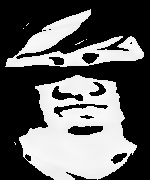

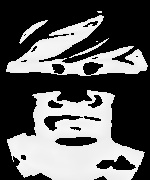

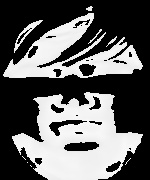

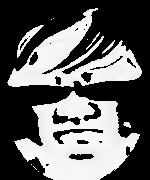

A total of 4 frame(s) has been loaded from file ./dataset/anger/chinha2.svx


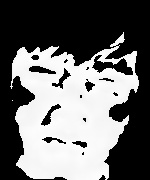

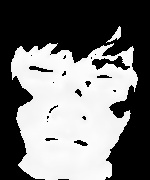

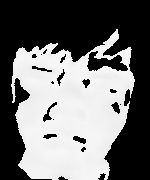

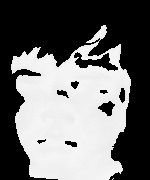

A total of 4 frame(s) has been loaded from file ./dataset/anger/Nhatangry1.svx


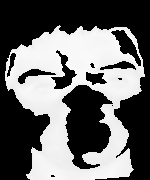

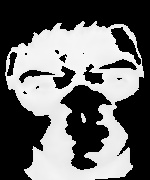

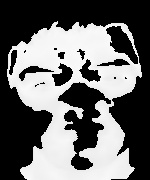

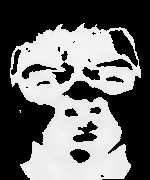

A total of 4 frame(s) has been loaded from file ./dataset/anger/quana1.svx


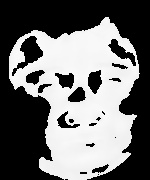

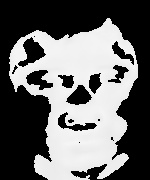

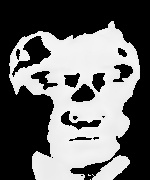

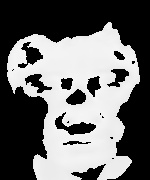

A total of 4 frame(s) has been loaded from file ./dataset/anger/vieta1.svx


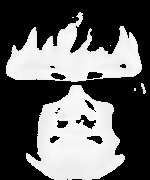

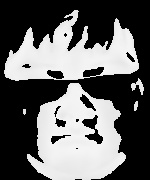

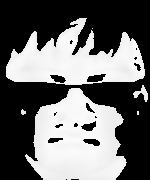

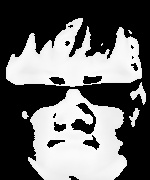

A total of 4 frame(s) has been loaded from file ./dataset/anger/Nama1.svx


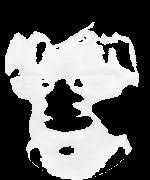

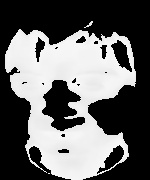

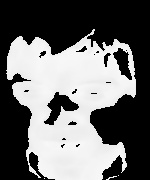

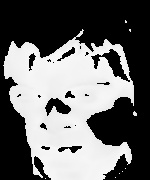

A total of 4 frame(s) has been loaded from file ./dataset/anger/LamA1.svx


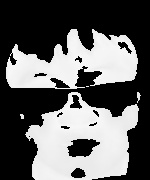

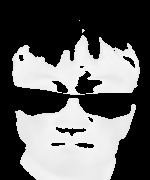

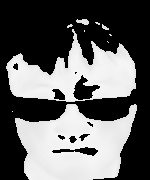

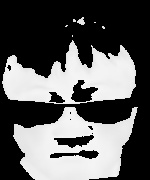

A total of 4 frame(s) has been loaded from file ./dataset/anger/nhata1.svx


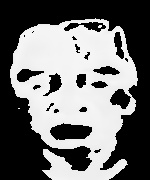

KeyboardInterrupt: 

<Figure size 2100x1000 with 0 Axes>

In [74]:
# Observe the dataset:
inputdata = dict()
plotIndex = 1
plt.figure(num=None,figsize=(21,10),dpi=100)
for e in eDir:
    eIntensities = []
    for file in getSVXFiles(dbDir+eDir[e]):
        # Get intensities:
        eIntensities.extend(readIntensitiesFromSVX(file, frame_step = 100))
        
        # Get TROIs:
        TROIs = readTROIsFromSVX(file, frame_step = 0.3)
        for img in TROIs:
            frameShow(np.array(img).reshape(180,150))
        print('A total of',len(TROIs), 'frame(s) has been loaded from file', file)
        
    inputdata[e] = np.average(eIntensities, axis = 0)
    print('Finished loading',e.upper())
    plt.subplot(2, 3, plotIndex)
    plt.plot(np.arange(0, 256), inputdata[e], alpha = 1)
    plt.axis([180, 255, 0, 0.07])
    plt.xlabel('Grayscale')
    plt.ylabel('Intensity')
    plt.title(e.upper())
    plotIndex += 1
    
# plt.tight_layout()
plt.show()

#### Load features using intensities:

In [ ]:
# import re
# regexPattern = '/(\w+)(?:.svx|.SVX)'

# def getDataFrameFromSVXs(dbLocation, frame_limit):
#     eIntensities = []
#     for e in eDir:
#         for file in getSVXFiles(dbDir+eDir[e]):
#             print('Loading file', file)
#             trimmedFileName = re.findall(regexPattern, file)[0]
#             # Get rows of features:
#             rows = readIntensitiesFromSVX(file, frame_limit = frame_limit)
#             # Get label for each row:
#             for row in rows:
#                 row.append(trimmedFileName)
#                 row.append(e)
#             eIntensities.extend(rows)
#             print('Loaded file', file)
        
#         print('Finished loading',e.upper())
#     return pd.DataFrame(eIntensities, columns = list(map(str, range(180,256))) + ['Filename', 'Emotion'])

#### Save Intensities to CSV file

In [ ]:
# df = getDataFrameFromSVXs(dbDir,20000)
# df.to_csv('./GrayscaleIntensities/intensities_v2.csv', index = False)
# print("Finished exporting data to csv")
# df.head()
# getDataFrameFromSVXs(dbDir).head()

#### Load features using TROIs:

In [10]:
import re
regexPattern = '/(\w+)(?:.svx|.SVX)'

def getDataFrameFromSVXs(dbLocation, frame_limit, frame_step):
    eTROIs = []
    for e in eDir:
        for file in getSVXFiles(dbDir+eDir[e]):
            print('Loading file', file)
            # Get rows of features:
            rows = readTROIsFromSVX(file, frame_limit = frame_limit, frame_step = frame_step)
            # Add filename and label for each row:
            trimmedFileName = re.findall(regexPattern, file)[0]
            for row in rows:
                row.append(trimmedFileName)
                row.append(e)
            eTROIs.extend(rows)
            print('Loaded file', file)
        print('Finished loading',e.upper())
    return pd.DataFrame(eTROIs, columns = list(map(str, range(150*180))) + ['Filename', 'Emotion'])

In [11]:
df = getDataFrameFromSVXs(dbDir, frame_limit = 20000, frame_step = 0.1)
print(df)

Loading file ./dataset/anger/chinha2.svx
Loaded file ./dataset/anger/chinha2.svx
Loading file ./dataset/anger/Nhatangry1.svx
Loaded file ./dataset/anger/Nhatangry1.svx
Loading file ./dataset/anger/quana1.svx
Loaded file ./dataset/anger/quana1.svx
Loading file ./dataset/anger/vieta1.svx
Loaded file ./dataset/anger/vieta1.svx
Loading file ./dataset/anger/Nama1.svx
Loaded file ./dataset/anger/Nama1.svx
Loading file ./dataset/anger/LamA1.svx
Loaded file ./dataset/anger/LamA1.svx
Loading file ./dataset/anger/nhata1.svx
Loaded file ./dataset/anger/nhata1.svx
Loading file ./dataset/anger/cuonga1.svx
Loaded file ./dataset/anger/cuonga1.svx
Loading file ./dataset/anger/anan1.svx
Loaded file ./dataset/anger/anan1.svx
Loading file ./dataset/anger/thoa1.SVX
Loaded file ./dataset/anger/thoa1.SVX
Loading file ./dataset/anger/maya1vx.SVX
Loaded file ./dataset/anger/maya1vx.SVX
Loading file ./dataset/anger/nguyetanger1.SVX
Loaded file ./dataset/anger/nguyetanger1.SVX
Loading file ./dataset/anger/thaoa

In [12]:
df.to_csv('./TROIs/TROIs.csv', index = False)

#### Load data from csv

In [13]:
data = pd.read_csv('./TROIs/TROIs.csv')
data.head()

,0,1,2,3,4,5,6,7,8,9,...,26992,26993,26994,26995,26996,26997,26998,26999,Filename,Emotion
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,chinha2,angry
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,chinha2,angry
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,chinha2,angry
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,chinha2,angry
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,chinha2,angry


#### Train-Test split

In [14]:
# from sklearn.model_selection import train_test_split
# train, test = train_test_split(data, test_size = 0.25, random_state = 1, shuffle = True)

def train_test_split(data, train_part=2, total_part=3):
    # Get a map from each filename to the emotion it express:
    map_file_emotion = dict(zip(data['Filename'].tolist(), data['Emotion'].tolist()))

    # Get a map from each emotion to a list of files of that emotion:
    map_emotion_files = dict((e, [f for f in map_file_emotion if map_file_emotion[f] == e]) for e in set(map_file_emotion.values()))

    # Decide whether a file belongs to train set or test set:
    map_file_traintest = dict()
    for files in map_emotion_files.values():
        for i in range(len(files)):
            map_file_traintest[files[i]] = 'train' if i < len(files)*train_part//total_part else 'test'

    # Split data into train set and test set with given map_file_traintest:
    train = []
    test = []
    for i in range(len(data)):
        try:
            if map_file_traintest[data['Filename'][i]] == 'train':
                train.append(data.loc[i])
            else:
                test.append(data.loc[i])
        except:
            print(data['Filename'][i])
    train =  pd.DataFrame(train, columns = list(map(str, range(150*180))) + ['Filename', 'Emotion'])
    test =  pd.DataFrame(test, columns = list(map(str, range(150*180))) + ['Filename', 'Emotion'])
    
    return train, test

In [15]:
train, test = train_test_split(data)

In [16]:
train.to_csv('./TROIs/train.csv', index = False)
test.to_csv('./TROIs/test.csv', index = False)

#### Load train and test from csv

In [17]:
train = pd.read_csv('./TROIs/train.csv')
test = pd.read_csv('./TROIs/test.csv')

In [18]:
print(train.shape, test.shape, sep='\n')

(770, 27002)
(407, 27002)


#### Splitting label out of trainning, testing set (* Skip these splitting step for saving memory)

In [19]:
train = train.sample(frac = 1, random_state = 1998)
test = test.sample(frac = 1, random_state = 1998)

In [109]:
X_train = train.iloc[:, 0:-2]
Y_train = train.iloc[:, -1]
X_test = test.iloc[:, 0:-2]
Y_test = test.iloc[:, -1]

# X_train.head()
# Y_train.head()
# X_test.head()
for e in eDir: 
    print(e,Y_test.tolist().count(e))
    
print("Train - PCA: ", X_train.shape)
print("Test - PCA: ", X_test.shape)

angry 55
fear 88
happy 88
sad 88
neutral 88
Train - PCA:  (770, 27000)
Test - PCA:  (407, 27000)


### Standardize dataset and apply PCA

In [110]:
# Standardize dataset:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
X_train = std_scaler.fit_transform(X_train)
X_test = std_scaler.transform(X_test)

# Apply PCA:
from sklearn.decomposition import PCA

PCA_ncomp = 0.95
pca = PCA(n_components = PCA_ncomp)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

X_train = pd.DataFrame(data = X_train)#, columns = list(map(str, range(PCA_ncomp))))
X_test = pd.DataFrame(data = X_test)#, columns = list(map(str, range(PCA_ncomp))))

print("Train - PCA: ", X_train.shape)
print("Test - PCA: ", X_test.shape)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  """


Train - PCA:  (770, 473)
Test - PCA:  (407, 473)


In [103]:
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,-197.424605,24.775550,-29.520755,-7.642262,-12.867560,-2.130768,-3.229048,-8.287461,-4.340048,5.336579,...,1.329360,0.062214,2.768875,7.053766,-2.612923,-2.166274,-1.983492,0.203612,-10.328628,-1.697933
1,-195.865320,25.637946,-33.266511,-11.248084,-14.273559,1.759897,-2.855578,-4.737171,12.885074,11.116640,...,0.406685,-1.258698,2.072666,2.278248,-5.347474,2.408921,-2.970550,-4.444290,-15.512081,5.083691
2,-202.585694,28.282935,-35.865458,-12.213060,8.560541,-0.346061,-7.451018,-10.104988,-2.530413,9.594655,...,-6.844570,-19.560921,-2.938638,-12.402191,9.963851,-2.329284,13.777984,6.935833,4.047961,8.622005
3,-197.996016,24.528148,-32.382784,-8.725748,-13.723954,-2.265310,-3.838504,-10.357516,-2.122617,6.729718,...,-0.603174,-1.374435,1.105201,3.419615,-0.247726,2.806172,-3.460982,-5.931088,-11.310597,-1.368733
4,-199.289790,26.824920,-31.427894,-9.768811,-13.719811,0.259039,-5.959914,-6.884623,-3.638638,7.274337,...,0.051632,2.678113,-1.294023,8.535517,-6.848828,-3.957440,-4.969039,1.629769,-3.705899,-26.585370


### Training, Cross Validating with XGBoost

Param: 0.1 -- Overall accuracy: 0.2310
Detail result:
              precision    recall  f1-score   support

       angry       0.31      0.44      0.36        39
        fear       0.22      0.23      0.22        83
       happy       0.16      0.13      0.15       105
     neutral       0.20      0.40      0.27        45
         sad       0.30      0.19      0.23       135

   micro avg       0.23      0.23      0.23       407
   macro avg       0.24      0.28      0.25       407
weighted avg       0.24      0.23      0.22       407

Confusion matrix:
         p_angry  p_fear  p_happy  p_neutral  p_sad
angry         17      12        8          0      2
fear           4      19       21         14     25
happy         25      17       14         28     21
neutral        5       2        6         18     14
sad            4      38       39         28     26


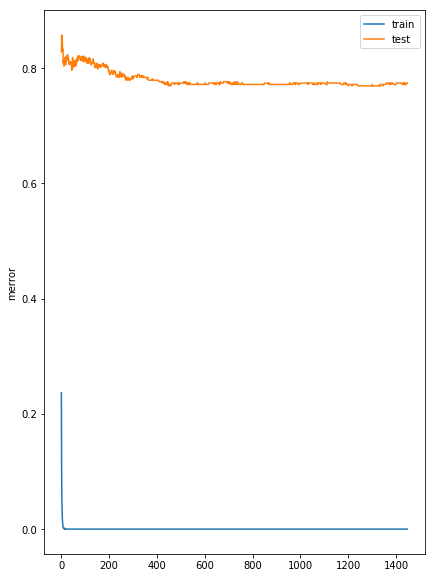

Param: 0.3 -- Overall accuracy: 0.2064
Detail result:
              precision    recall  f1-score   support

       angry       0.15      0.26      0.19        31
        fear       0.14      0.17      0.15        69
       happy       0.18      0.18      0.18        91
     neutral       0.20      0.32      0.25        56
         sad       0.34      0.19      0.24       160

   micro avg       0.21      0.21      0.21       407
   macro avg       0.20      0.22      0.20       407
weighted avg       0.24      0.21      0.21       407

Confusion matrix:
         p_angry  p_fear  p_happy  p_neutral  p_sad
angry          8      12        9          0      2
fear           4      12       16         19     18
happy         18      14       16         23     20
neutral        5       8        7         18     18
sad           20      42       40         28     30


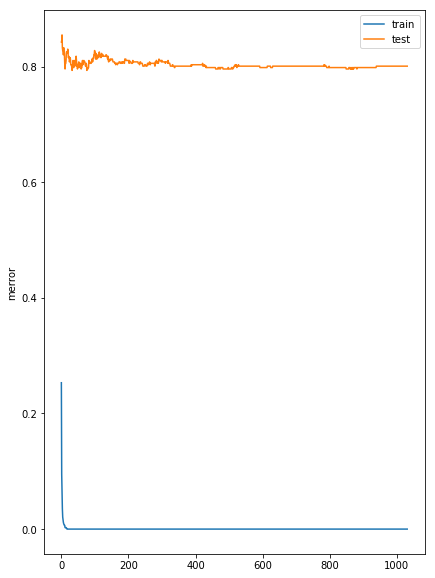

Param: 0.5 -- Overall accuracy: 0.1966
Detail result:
              precision    recall  f1-score   support

       angry       0.20      0.44      0.28        25
        fear       0.25      0.22      0.24        98
       happy       0.19      0.14      0.17       118
     neutral       0.11      0.26      0.16        38
         sad       0.23      0.16      0.19       128

   micro avg       0.20      0.20      0.20       407
   macro avg       0.20      0.25      0.20       407
weighted avg       0.21      0.20      0.19       407

Confusion matrix:
         p_angry  p_fear  p_happy  p_neutral  p_sad
angry         11      10        4          0      0
fear           9      22       21         21     25
happy         18      21       17         33     29
neutral        8       2        4         10     14
sad            9      33       42         24     20


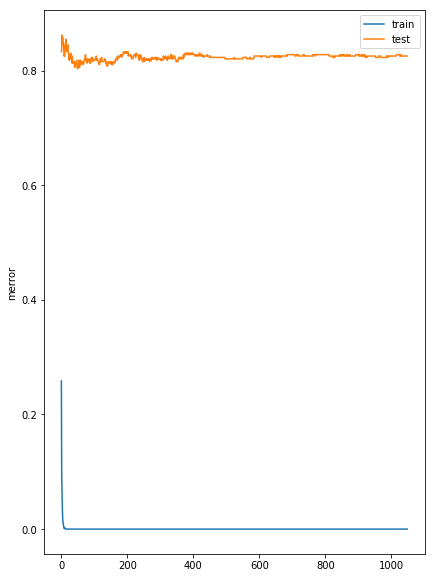

Param: 1 -- Overall accuracy: 0.1941
Detail result:
              precision    recall  f1-score   support

       angry       0.27      0.22      0.25        67
        fear       0.07      0.10      0.08        58
       happy       0.20      0.19      0.20        96
     neutral       0.15      0.24      0.18        54
         sad       0.31      0.20      0.25       132

   micro avg       0.19      0.19      0.19       407
   macro avg       0.20      0.19      0.19       407
weighted avg       0.22      0.19      0.20       407

Confusion matrix:
         p_angry  p_fear  p_happy  p_neutral  p_sad
angry         15      18       17          7     10
fear           7       6       11         19     15
happy         12      14       18         27     25
neutral        6      12       12         13     11
sad           15      38       30         22     27


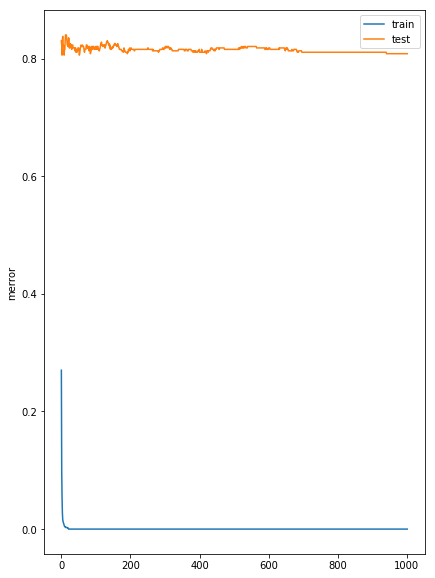

In [112]:
from sklearn.metrics import classification_report, confusion_matrix

metrics = ['merror']
for d in [0.1, 0.3, 0.5, 1]:
    clf = XGBClassifier(
#         objective = 'multi:softprob',
        num_class = len(eDir),
        eta = 0.00001, 
        max_depth = 80, 
        n_estimators = 10000, 
        n_jobs = 6, 
        subsample = 0.5, 
        min_child_weight = 0,
        colsample_bytree = 1,
        tree_method = 'approx',
        reg_lambda = d
    )
    
    clf.fit(
        X=X_train, y=Y_train, 
        eval_set=[(X_train, Y_train),(X_test, Y_test)],
        eval_metric=metrics, 
        early_stopping_rounds = 1000, 
        verbose = 0
    )
    eval_res = clf.evals_result()
    acc = clf.score(X_test, Y_test)
    print("Param:",d,"-- Overall accuracy: {:.4f}".format(acc))
    clf.save_model('./model/model_xgboost.model')
    plt.figure(num=None, figsize=(15,10))
    for i,metric in enumerate(metrics):
        plt.subplot(120 + i + 1)
        plt.plot(eval_res['validation_0'][metric], label = 'train')
        plt.plot(eval_res['validation_1'][metric], label = 'test')
        plt.legend()
        plt.ylabel(metric)
    Y_predict = clf.predict(X_test)
    result = classification_report(Y_predict, Y_test)
    confusionMatrix = pd.DataFrame(data = confusion_matrix(Y_predict, Y_test), columns = ["p_" + c for c in sorted(list(eDir.keys()))], index = sorted(list(eDir.keys())))
    print("Detail result:", result, sep = '\n')
    print("Confusion matrix:", confusionMatrix, sep = '\n')
    plt.show()
    

### Training, Cross Validating using Random Forest

In [88]:
from sklearn.ensemble import RandomForestClassifier
tree = 1
result = (0.0, 1)
early_stopping_round = 200
turn = 1
train_accs = np.array()
test_accs = np.array()
while True:
    clf = RandomForestClassifier(n_estimators = tree, 
                                 max_depth = 10,
                                 min_samples_split = 5, 
                                 n_jobs=6,
                                 random_state = 1998)
    
    clf.fit(X_train, Y_train)
    train_acc = clf.score(X_train, Y_train)
    test_acc = clf.score(X_test, Y_test)
    print(tree)
    print('train accuracy:', train_acc)
    print('test accuracy:', test_acc)
    
    train_accs.append(np.array((tree, train_acc)))
    test_accs.append(np.array((tree, test_acc)))
    
    early_stopping_round -= 1
    if test_acc > result[0]:
        turn = 0
        result = test_acc, tree
    elif turn == early_stopping_round or tree == 1000:
        print('End in turn:', turn)
        break
    tree += 1
    turn += 1
print('Best accuracy on test set:', result[0], '-- tree:', result[1])
plt.figure(num=None, figsize=(15,15))
plt.plot(train_accs[0], train_accs[1])
plt.plot(test_accs[0], test_accs[1])

781
train accuracy: 1.0
test accuracy: 0.3071253071253071
782
train accuracy: 1.0
test accuracy: 0.3071253071253071
783
train accuracy: 1.0
test accuracy: 0.3071253071253071
784
train accuracy: 1.0
test accuracy: 0.3046683046683047
785
train accuracy: 1.0
test accuracy: 0.3046683046683047
786
train accuracy: 1.0
test accuracy: 0.3046683046683047
787
train accuracy: 1.0
test accuracy: 0.3046683046683047
788
train accuracy: 1.0
test accuracy: 0.3046683046683047
789
train accuracy: 1.0
test accuracy: 0.3022113022113022
790
train accuracy: 1.0
test accuracy: 0.3022113022113022
791
train accuracy: 1.0
test accuracy: 0.3022113022113022
792
train accuracy: 1.0
test accuracy: 0.3022113022113022
793
train accuracy: 1.0
test accuracy: 0.3046683046683047
794
train accuracy: 1.0
test accuracy: 0.3022113022113022
795
train accuracy: 1.0
test accuracy: 0.3022113022113022
796
train accuracy: 1.0
test accuracy: 0.3022113022113022
797
train accuracy: 1.0
test accuracy: 0.3022113022113022
798
train accu

In [90]:
print("Train: ", train.shape)
print("Test: ", test.shape)
print("Train - PCA: ", X_train.shape)
print("Test - PCA: ", X_test.shape)

Train:  (770, 27002)
Test:  (407, 27002)
Train - PCA:  (770, 110)
Test - PCA:  (407, 110)
